In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
# from torchvision.models import EfficientNet
from torchvision.models.resnet import ResNet50_Weights

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

from torchsampler import ImbalancedDatasetSampler


In [2]:
# Hyperparameters
learning_rate = 0.001379 # 0.096779
epochs = 1 #300
epochs_pretrain = 1 #3
epochs_optimal_lr = 1 #5
patience_teacher = 7
patience_student = 10
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
batch_size = 128
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = True
balance_data = False

# list of lambda values to loop through for grid search
lmda_list_student = [0,3,5]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(num_classes):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = ['RandAugment'], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')

if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)

elif balance_data:
    # Use ImbalancedDatasetSampler for the training dataset
    trainloader = DataLoader(train_dataset, sampler=ImbalancedDatasetSampler(train_dataset), 
                             batch_size=batch_size, num_workers=num_workers, collate_fn=custom_collate)
    # For test dataset, you can continue using the regular DataLoader without the sampler
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)
    
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

In [12]:
def print_batch_class_counts(data_loader, num_batches=5):
    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break

        # Extract labels from the batch
        labels = batch['label']

        # Count occurrences of each class
        class_counts = torch.bincount(labels)

        # Print class counts and total observations
        print(f"Batch {i+1}:")
        print(f"Class Counts: {class_counts}")
        print(f"Total Observations: {len(labels)}")

# Example usage
print_batch_class_counts(trainloader)


Batch 1:
Class Counts: tensor([25, 11, 11,  5, 14,  3,  2,  7,  7,  7,  7,  2,  5,  7,  8,  9])
Total Observations: 130
Batch 2:
Class Counts: tensor([25, 11, 11,  5, 14,  3,  2,  7,  7,  7,  7,  2,  5,  7,  8,  9])
Total Observations: 130
Batch 3:
Class Counts: tensor([25, 11, 11,  5, 14,  3,  2,  7,  7,  7,  7,  2,  5,  7,  8,  9])
Total Observations: 130
Batch 4:
Class Counts: tensor([25, 11, 11,  5, 14,  3,  2,  7,  7,  7,  7,  2,  5,  7,  8,  9])
Total Observations: 130
Batch 5:
Class Counts: tensor([25, 11, 11,  5, 14,  3,  2,  7,  7,  7,  7,  3,  4,  7,  8,  8])
Total Observations: 129


# Start Training Process

In [13]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [14]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
# teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
# teacher_model.classifier = nn.Linear(1536, num_classes)
# student_model = torchvision.models.efficientnet_b0(weights=None)
# student_model.classifier = nn.Linear(1280, num_classes)
teacher_model = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
teacher_model.fc = nn.Linear(2048, num_classes)
student_model = torchvision.models.resnet18(weights=None)
student_model.fc = nn.Linear(512, num_classes)


# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [15]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [16]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [18]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [19]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [20]:
# #### finding the optimal learning rate
# def train_teacher_optimal_lr(model, trainloader, criterion, optimizer, scheduler, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Teacher')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Teacher: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_teacher = train_teacher_optimal_lr(teacher_model, trainloader, criterion_clf, teacher_optimizer, teacher_scheduler, device, epochs_optimal_lr)  
# print(best_lr_teacher)


In [21]:
# #### finding the optimal learning rate
# def train_student_optimal_lr(model, trainloader, criterion, optimizer, device, epochs_optimal_lr=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), epochs_optimal_lr * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(epochs_optimal_lr):
#         for i, batch in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = batch['img'].to(device), batch['label'].to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test - Student')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best Learning Rate Student: {best_lr}')
#     return best_lr

# ############# input ############## 
# best_lr_student = train_student_optimal_lr(student_model, trainloader, criterion_clf, student_optimizer, device, epochs_optimal_lr)  
# print(best_lr_student)

In [22]:
best_lr_student = learning_rate
best_lr_teacher = learning_rate

In [23]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [24]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [25]:
# Function to train the teacher model
def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        # Train the adversary at the start of each epoch
        train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epochs}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:19<00:00,  1.42it/s]


*****Epoch 1/1*****
*****Train Loss:  2.666209 Val Loss:  2.394900*****
*****Validation Accuracy: 23.98%*****
*****Total Avg Disparity: 0.023049065466437636*****

Class Team_Sports: Recall Difference = 0.012191276931161399
Class Celebration: Recall Difference = 0.0
Class Parade: Recall Difference = -0.06621043627031648
Class Waiter_Or_Waitress: Recall Difference = 0.0
Class Individual_Sports: Recall Difference = 0.03630925336968044
Class Surgeons: Recall Difference = 0.0
Class Spa: Recall Difference = 0.0
Class Law_Enforcement: Recall Difference = 0.0
Class Business: Recall Difference = -0.002560546249866638
Class Dresses: Recall Difference = 0.0
Class Water Activities: Recall Difference = -0.0087567567567568
Class Picnic: Recall Difference = 0.0
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Difference = 0.03364852202061504
Class Family: Recall Difference = 0.0016666666666666705


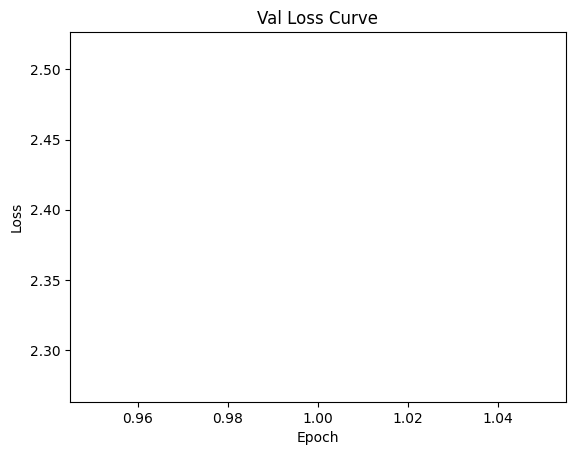

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [26]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    # teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # # Replace the last fully connected layer with a new one
    # teacher_model.classifier = nn.Linear(1536, num_classes)
    # teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)

    # Reset the teacher model for each lambda
    teacher_model = torchvision.models.resnet50(weights=None).to(device)
    teacher_model.fc = nn.Linear(2048, num_classes)
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=best_lr_teacher)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_teacher)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


*******Epoch 0: loss - 0.2635285992175341


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


Average Pretrain Adversary epoch loss:  0.376255014911294


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:49<00:00,  1.37s/it]


Average Adversary epoch loss: 0.256500237621367


100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:18<00:00,  1.44it/s]


*****Epoch 1/1*****
*****Train Loss:  0.238270 Val Loss:  0.240243*****
*****Validation Accuracy: 31.28%*****
*****Total Avg Disparity: 0.12520403018085313*****

Class Team_Sports: Recall Difference = 0.0948093653295966
Class Celebration: Recall Difference = 0.0069767441860465115
Class Parade: Recall Difference = 0.0003992015968063978
Class Waiter_Or_Waitress: Recall Difference = -0.059177068885806754
Class Individual_Sports: Recall Difference = -0.007950931394820504
Class Surgeons: Recall Difference = -0.13229859571322986
Class Spa: Recall Difference = -0.52
Class Law_Enforcement: Recall Difference = 0.09484484484484487
Class Business: Recall Difference = -0.1362423983783207
Class Dresses: Recall Difference = -0.10704607046070458
Class Water Activities: Recall Difference = 0.02659459459459451
Class Picnic: Recall Difference = 0.5454545454545454
Class Rescue: Recall Difference = 0.012658227848101267
Class Cheering: Recall Difference = -0.010869565217391306
Class Performance_And_Enterta

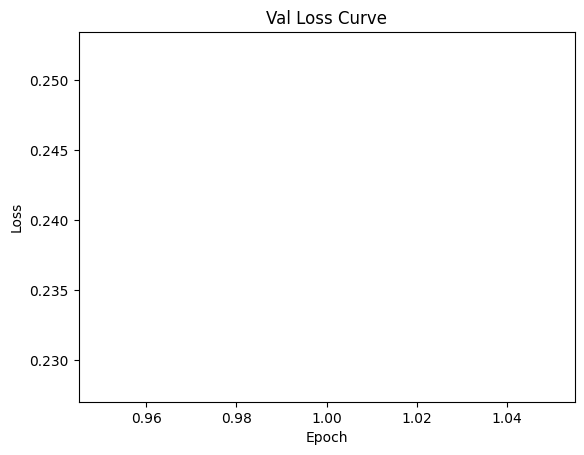

Student weights and architecture saved and exported for lambda: 0


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


*******Epoch 0: loss - 0.2621486967429519


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:54<00:00,  1.43s/it]


Average Pretrain Adversary epoch loss:  0.4085239198058844


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:48<00:00,  1.36s/it]


Average Adversary epoch loss: 0.24405893143266438


100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:18<00:00,  1.44it/s]


*****Epoch 1/1*****
*****Train Loss:  0.237621 Val Loss:  0.250043*****
*****Validation Accuracy: 28.23%*****
*****Total Avg Disparity: 0.07744457040615753*****

Class Team_Sports: Recall Difference = 0.03897938926840666
Class Celebration: Recall Difference = -0.046511627906976744
Class Parade: Recall Difference = -0.020017108639863168
Class Waiter_Or_Waitress: Recall Difference = -0.12713823393435042
Class Individual_Sports: Recall Difference = -0.0926472815386945
Class Surgeons: Recall Difference = -0.08425720620842568
Class Spa: Recall Difference = -0.04
Class Law_Enforcement: Recall Difference = 0.1819319319319319
Class Business: Recall Difference = -0.07361570468366585
Class Dresses: Recall Difference = -0.02913279132791327
Class Water Activities: Recall Difference = 0.04032432432432431
Class Picnic: Recall Difference = -0.27272727272727276
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = -0.03465955701394584
Class Performance_And_Entertainment: Recall Dif

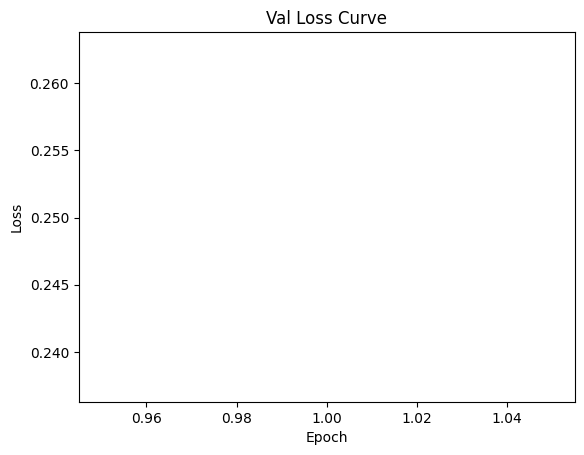

Student weights and architecture saved and exported for lambda: 3


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.40s/it]


*******Epoch 0: loss - 0.2629953997209668


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:51<00:00,  1.40s/it]


Average Pretrain Adversary epoch loss:  0.40237657763063905


100%|███████████████████████████████████████████████████████████████████████████| 80/80 [01:47<00:00,  1.35s/it]


Average Adversary epoch loss: 0.24590247254818678


100%|███████████████████████████████████████████████████████████████████████████| 27/27 [00:18<00:00,  1.44it/s]


*****Epoch 1/1*****
*****Train Loss:  0.238891 Val Loss:  0.249357*****
*****Validation Accuracy: 29.26%*****
*****Total Avg Disparity: 0.0934800379238889*****

Class Team_Sports: Recall Difference = 0.09497284988614474
Class Celebration: Recall Difference = -0.058139534883720964
Class Parade: Recall Difference = -0.04453949244368427
Class Waiter_Or_Waitress: Recall Difference = -0.049468331021729074
Class Individual_Sports: Recall Difference = -0.02237619263970922
Class Surgeons: Recall Difference = 0.024390243902439022
Class Spa: Recall Difference = -0.38000000000000006
Class Law_Enforcement: Recall Difference = 0.10010010010010006
Class Business: Recall Difference = -0.039368398591699556
Class Dresses: Recall Difference = -0.2926829268292683
Class Water Activities: Recall Difference = 0.0765405405405406
Class Picnic: Recall Difference = 2.7755575615628914e-17
Class Rescue: Recall Difference = 0.0
Class Cheering: Recall Difference = 0.0
Class Performance_And_Entertainment: Recall Dif

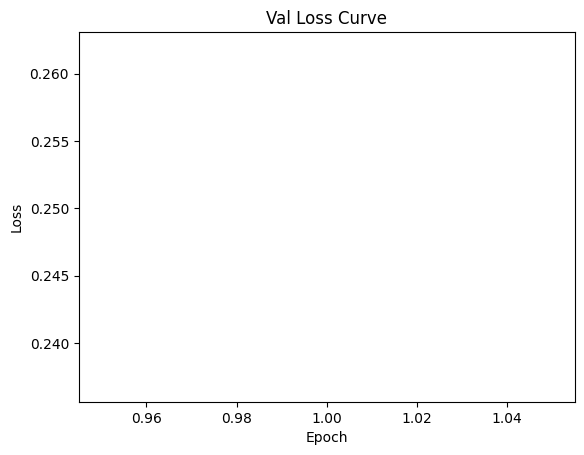

Student weights and architecture saved and exported for lambda: 5


In [28]:
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda0.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda0.pth'))
    teacher_model = teacher_model.to(device)
    
    # # Reset the student model for each lambda
    # student_model = torchvision.models.efficientnet_b0(weights=None)
    # student_model.classifier = nn.Linear(1280, num_classes)
    # student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_model = torchvision.models.resnet18(weights=None).to(device)
    student_model.fc = nn.Linear(512, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=best_lr_student)
    student_scheduler = torch.optim.lr_scheduler.StepLR(student_optimizer, step_size=step_size, gamma=gamma)
    
    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=best_lr_student)

    pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
    pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=0, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Check if the key exists in the dictionary
    if i not in lambda_results:
        # If not, create a new entry for that key
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }
    else:
        # If the key exists, update the existing entry
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })


In [29]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [35]:
# Loop through each lambda value for teachers and students
for lmda_teacher in lmda_list_teacher:
    for lmda_student in lmda_list_student:
        # Load teacher and student models for the current lambda
        teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')
        student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')

        # Compute performance metrics and other comparisons
        performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
        teacher_params, student_params = compare_model_size(teacher_model, student_model)
        teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

        # Lambda key as a tuple of teacher and student lambda values
        lambda_key = (lmda_teacher, lmda_student)

        # Update results for the current lambda combination
        if lambda_key in lambda_results:
            lambda_results[lambda_key].update({
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params,
                'teacher_time': teacher_time,
                'student_time': student_time
            })
        else:
            lambda_results[lambda_key] = {
                'performance_metrics': performance_metrics,
                'teacher_params': teacher_params,
                'student_params': student_params,
                'teacher_time': teacher_time,
                'student_time': student_time
            }


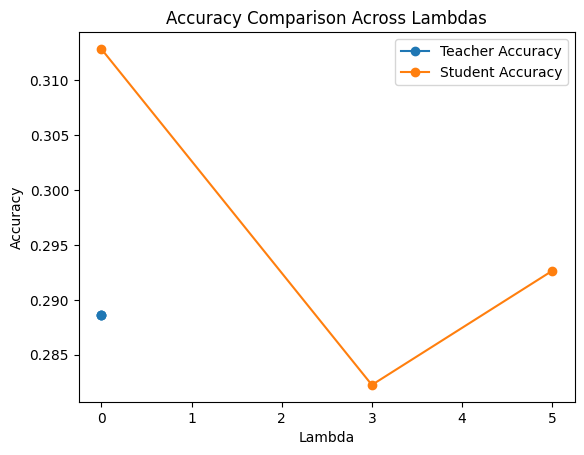

In [38]:
# Initialize lists to store accuracies
teacher_accuracies = []
student_accuracies = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Access the performance metrics for each pair
    teacher_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][0]
    student_accuracy = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['accuracy'][1]

    # Append accuracies to the lists
    teacher_accuracies.append((lmda_teacher, teacher_accuracy))
    student_accuracies.append((lmda_student, student_accuracy))

# To plot, you might need to separate the lambda values and accuracies
teacher_lambdas, teacher_acc = zip(*teacher_accuracies)
student_lambdas, student_acc = zip(*student_accuracies)

# Plotting
plt.plot(teacher_lambdas, teacher_acc, label='Teacher Accuracy', marker='o')
plt.plot(student_lambdas, student_acc, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


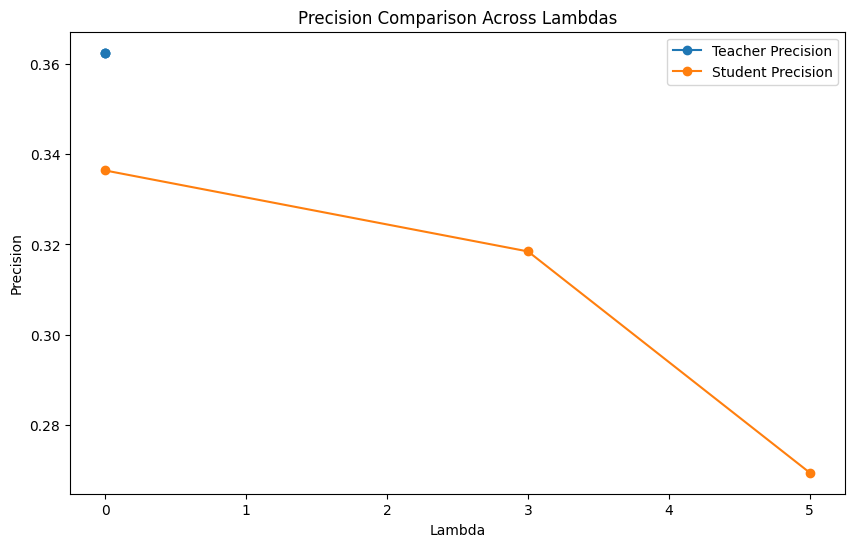

In [41]:
# Initialize lists to store precisions
teacher_precisions = []
student_precisions = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the precision metrics for each pair
        teacher_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][0]
        student_precision = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['precision'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append precisions to the lists along with lambda values
    teacher_precisions.append((lmda_teacher, teacher_precision))
    student_precisions.append((lmda_student, student_precision))

# To plot, you might need to separate the lambda values and precisions
teacher_lambdas, teacher_prec = zip(*teacher_precisions)
student_lambdas, student_prec = zip(*student_precisions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_prec, label='Teacher Precision', marker='o')
plt.plot(student_lambdas, student_prec, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


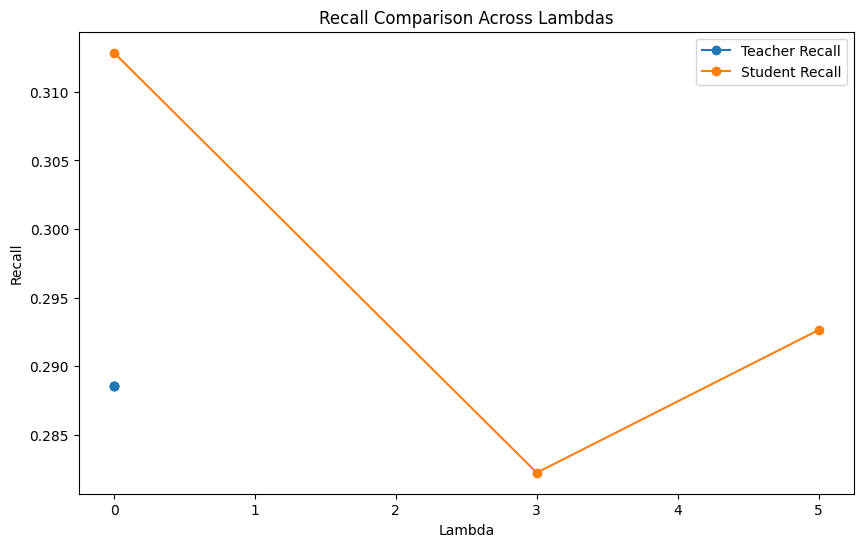

In [43]:
# Initialize lists to store recalls
teacher_recalls = []
student_recalls = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the recall metrics for each pair
        teacher_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][0]
        student_recall = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['recall'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append recalls to the lists along with lambda values
    teacher_recalls.append((lmda_teacher, teacher_recall))
    student_recalls.append((lmda_student, student_recall))

# To plot, you might need to separate the lambda values and recalls
teacher_lambdas, teacher_rec = zip(*teacher_recalls)
student_lambdas, student_rec = zip(*student_recalls)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_rec, label='Teacher Recall', marker='o')
plt.plot(student_lambdas, student_rec, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


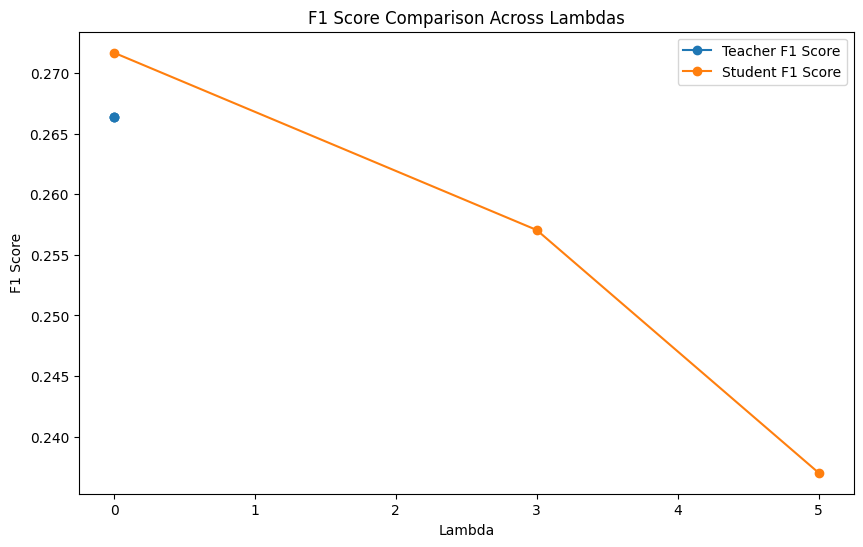

In [45]:
# Initialize lists to store F1 scores
teacher_f1s = []
student_f1s = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the F1 scores for each pair
        teacher_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][0]
        student_f1 = lambda_results[(lmda_teacher, lmda_student)]['performance_metrics']['metrics']['f1'][1]
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append F1 scores to the lists along with lambda values
    teacher_f1s.append((lmda_teacher, teacher_f1))
    student_f1s.append((lmda_student, student_f1))

# To plot, you might need to separate the lambda values and F1 scores
teacher_lambdas, teacher_f1_scores = zip(*teacher_f1s)
student_lambdas, student_f1_scores = zip(*student_f1s)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_f1_scores, label='Teacher F1 Score', marker='o')
plt.plot(student_lambdas, student_f1_scores, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


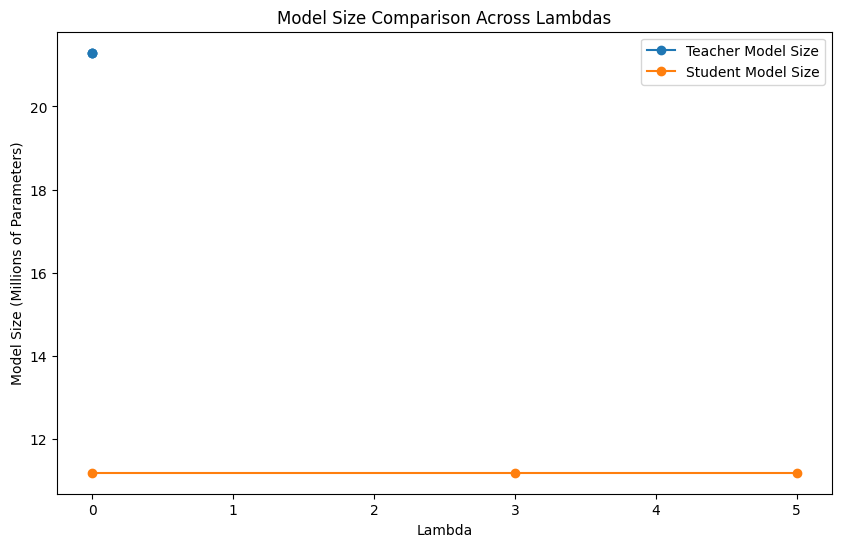

In [47]:
# Initialize lists to store model sizes
teacher_sizes = []
student_sizes = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the model sizes for each pair
        teacher_size = lambda_results[(lmda_teacher, lmda_student)]['teacher_params'] / 1e6  # Convert to millions
        student_size = lambda_results[(lmda_teacher, lmda_student)]['student_params'] / 1e6
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append model sizes to the lists along with lambda values
    teacher_sizes.append((lmda_teacher, teacher_size))
    student_sizes.append((lmda_student, student_size))

# To plot, you might need to separate the lambda values and model sizes
teacher_lambdas, teacher_model_sizes = zip(*teacher_sizes)
student_lambdas, student_model_sizes = zip(*student_sizes)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_model_sizes, label='Teacher Model Size', marker='o')
plt.plot(student_lambdas, student_model_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


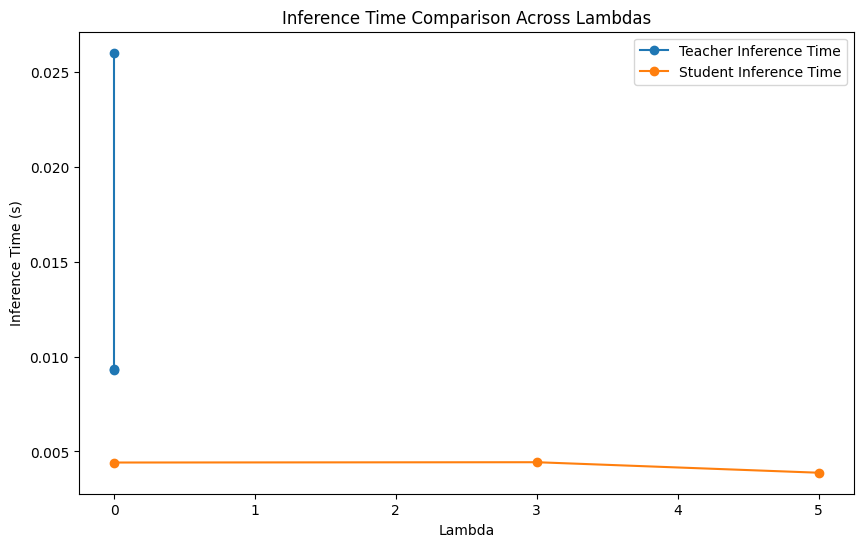

In [49]:
# Initialize lists to store inference times
teacher_times = []
student_times = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if the key is a tuple (indicating a lambda pair)
    if isinstance(key, tuple) and len(key) == 2:
        lmda_teacher, lmda_student = key
        # Access the inference times for each pair
        teacher_time = lambda_results[(lmda_teacher, lmda_student)]['teacher_time']
        student_time = lambda_results[(lmda_teacher, lmda_student)]['student_time']
    else:
        # If the key is not a tuple, skip this iteration
        continue

    # Append inference times to the lists along with lambda values
    teacher_times.append((lmda_teacher, teacher_time))
    student_times.append((lmda_student, student_time))

# To plot, you might need to separate the lambda values and inference times
teacher_lambdas, teacher_inference_times = zip(*teacher_times)
student_lambdas, student_inference_times = zip(*student_times)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(teacher_lambdas, teacher_inference_times, label='Teacher Inference Time', marker='o')
plt.plot(student_lambdas, student_inference_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


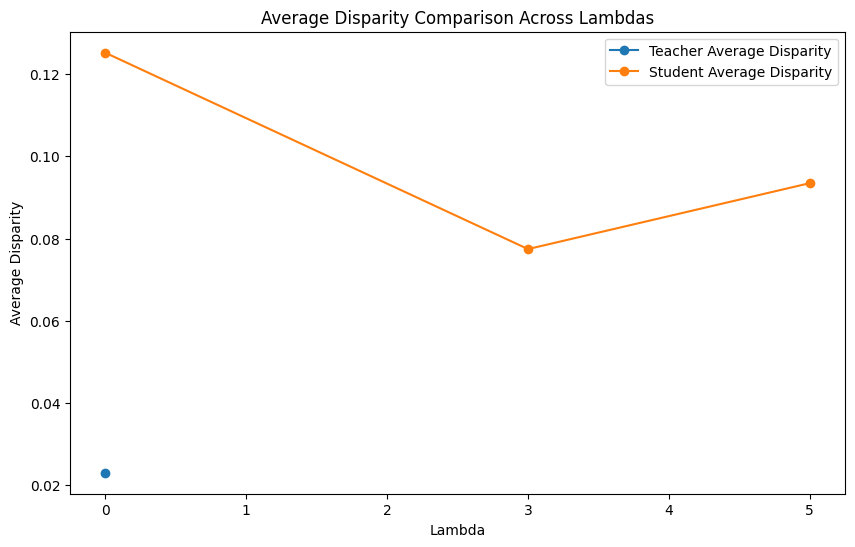

In [61]:
# Initialize lists to store disparity values
teacher_disparities = []
student_disparities = []
lambda_pairs = list(lambda_results.keys())

# Iterate over the keys in lambda_results
for key in lambda_pairs:
    # Check if it's an integer key (indicating a lambda value for student)
    if isinstance(key, int):
        # Check and extract teacher disparity if it exists
        if 'teacher_mean_abs_val_disparity' in lambda_results[key]:
            teacher_disparity = lambda_results[key]['teacher_mean_abs_val_disparity']
            if isinstance(teacher_disparity, list):  # Assuming the disparity could be stored as a list
                teacher_disparity = teacher_disparity[0]
            teacher_disparities.append((key, teacher_disparity))

        # Extract student disparity
        if 'student_mean_abs_val_disparity' in lambda_results[key]:
            student_disparity = lambda_results[key]['student_mean_abs_val_disparity']
            student_disparities.append((key, student_disparity))

# Separate the lambda values and disparity values
teacher_lambdas, teacher_disparity_values = zip(*teacher_disparities) if teacher_disparities else ([], [])
student_lambdas, student_disparity_values = zip(*student_disparities) if student_disparities else ([], [])

# Plotting
plt.figure(figsize=(10, 6))
if teacher_disparities:
    plt.plot(teacher_lambdas, teacher_disparity_values, label='Teacher Average Disparity', marker='o')
if student_disparities:
    plt.plot(student_lambdas, student_disparity_values, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


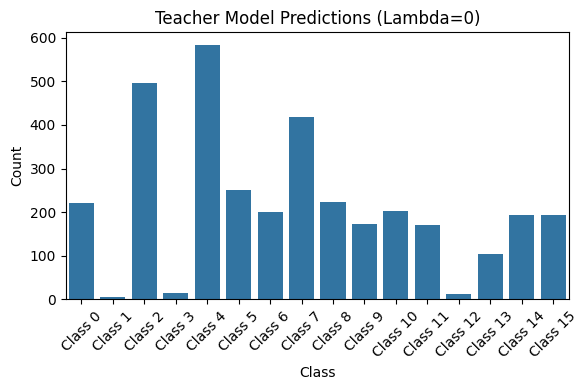

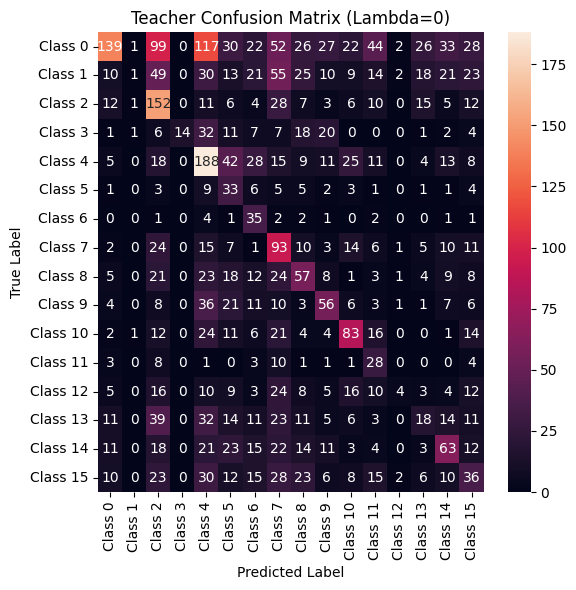

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.63      0.21      0.31       668
     Class 1       0.20      0.00      0.01       301
     Class 2       0.31      0.56      0.40       272
     Class 3       1.00      0.11      0.20       124
     Class 4       0.32      0.50      0.39       377
     Class 5       0.13      0.45      0.20        74
     Class 6       0.17      0.70      0.28        50
     Class 7       0.22      0.46      0.30       202
     Class 8       0.26      0.29      0.27       194
     Class 9       0.32      0.32      0.32       173
    Class 10       0.41      0.42      0.41       199
    Class 11       0.16      0.47      0.24        60
    Class 12       0.31      0.03      0.06       129
    Class 13       0.17      0.09      0.12       198
    Class 14       0.32      0.29      0.30       220
    Class 15       0.19      0.16      0.17       224

    accuracy                   

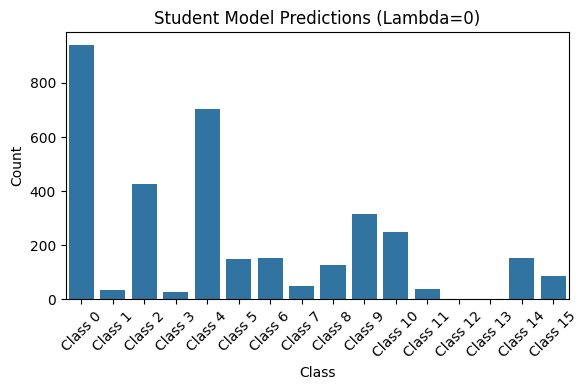

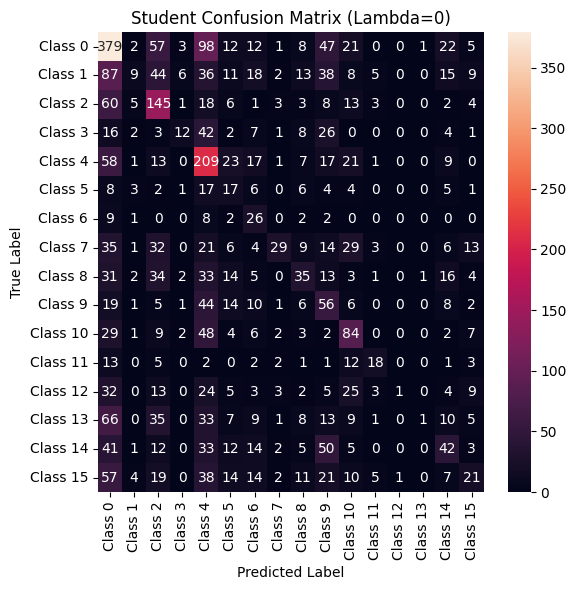

Classification Report - Student Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.40      0.57      0.47       668
     Class 1       0.27      0.03      0.05       301
     Class 2       0.34      0.53      0.41       272
     Class 3       0.43      0.10      0.16       124
     Class 4       0.30      0.55      0.39       377
     Class 5       0.11      0.23      0.15        74
     Class 6       0.17      0.52      0.25        50
     Class 7       0.58      0.14      0.23       202
     Class 8       0.28      0.18      0.22       194
     Class 9       0.18      0.32      0.23       173
    Class 10       0.34      0.42      0.37       199
    Class 11       0.45      0.30      0.36        60
    Class 12       0.50      0.01      0.02       129
    Class 13       0.33      0.01      0.01       198
    Class 14       0.27      0.19      0.23       220
    Class 15       0.24      0.09      0.14       224

    accuracy                   

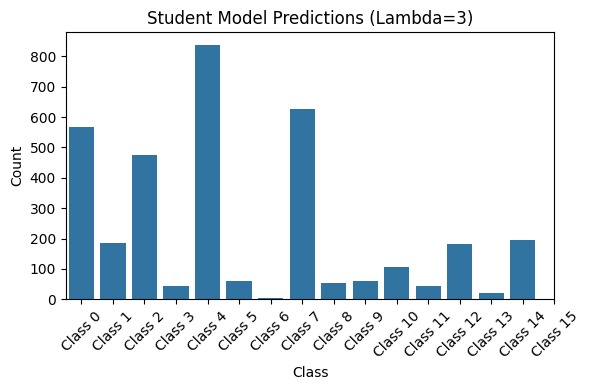

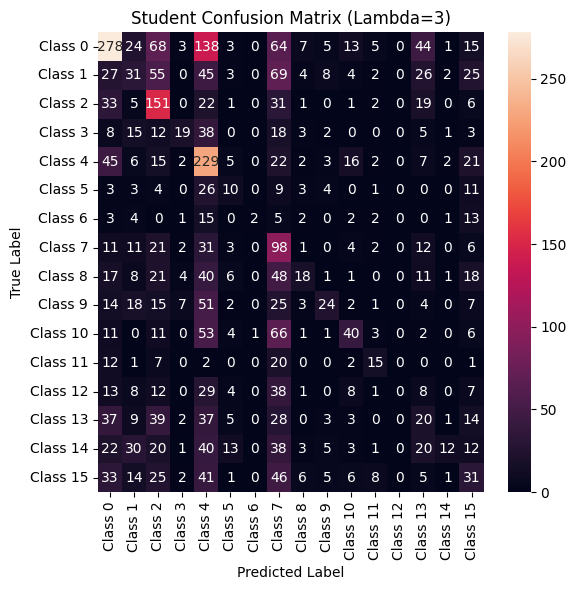

Classification Report - Student Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.49      0.42      0.45       668
     Class 1       0.17      0.10      0.13       301
     Class 2       0.32      0.56      0.40       272
     Class 3       0.44      0.15      0.23       124
     Class 4       0.27      0.61      0.38       377
     Class 5       0.17      0.14      0.15        74
     Class 6       0.67      0.04      0.08        50
     Class 7       0.16      0.49      0.24       202
     Class 8       0.33      0.09      0.14       194
     Class 9       0.39      0.14      0.21       173
    Class 10       0.38      0.20      0.26       199
    Class 11       0.33      0.25      0.29        60
    Class 12       0.00      0.00      0.00       129
    Class 13       0.11      0.10      0.10       198
    Class 14       0.55      0.05      0.10       220
    Class 15       0.16      0.14      0.15       224

    accuracy                   

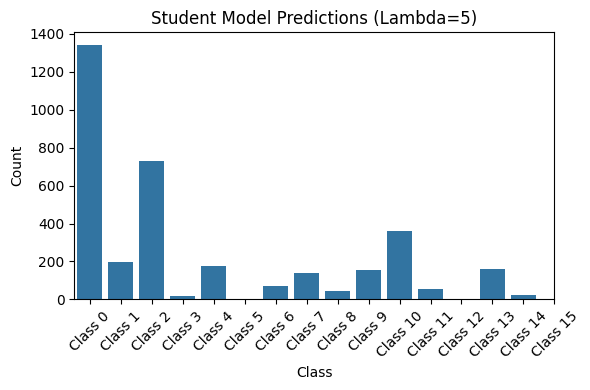

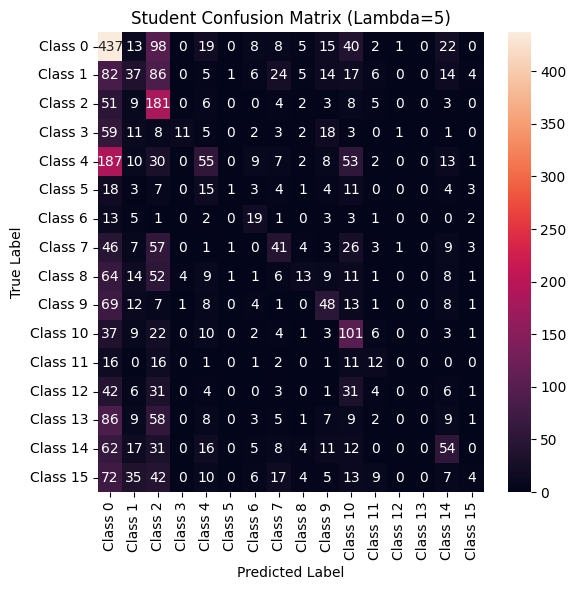

Classification Report - Student Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.33      0.65      0.44       668
     Class 1       0.19      0.12      0.15       301
     Class 2       0.25      0.67      0.36       272
     Class 3       0.69      0.09      0.16       124
     Class 4       0.32      0.15      0.20       377
     Class 5       0.25      0.01      0.03        74
     Class 6       0.28      0.38      0.32        50
     Class 7       0.30      0.20      0.24       202
     Class 8       0.30      0.07      0.11       194
     Class 9       0.31      0.28      0.29       173
    Class 10       0.28      0.51      0.36       199
    Class 11       0.22      0.20      0.21        60
    Class 12       0.00      0.00      0.00       129
    Class 13       0.00      0.00      0.00       198
    Class 14       0.34      0.25      0.28       220
    Class 15       0.18      0.02      0.03       224

    accuracy                   

In [66]:
def plot_distribution(predictions, class_names, title):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=predictions)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, predictions, class_names, title):
    cm = confusion_matrix(all_labels, predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(cm, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Function to generate predictions and compute metrics
def generate_predictions_and_metrics(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    return all_labels, all_preds

# Loop over each lambda value for the teacher model
for lmda_teacher in lmda_list_teacher:
    # Load the teacher model
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda{lmda_teacher}.pth')

    # Generate predictions for the teacher model
    all_labels, all_teacher_preds = generate_predictions_and_metrics(teacher_model, testloader)

    # Plot distribution and confusion matrix for the teacher model
    plot_distribution(all_teacher_preds, class_names_new, f'Teacher Model Predictions (Lambda={lmda_teacher})')
    plot_confusion_matrix(all_labels, all_teacher_preds, class_names_new, f'Teacher Confusion Matrix (Lambda={lmda_teacher})')

    # Print classification report for the teacher model
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda_teacher})')
    print(teacher_report)

# Loop over each lambda value for the student model
for lmda_student in lmda_list_student:
    # Load the student model
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda_student}.pth')

    # Generate predictions for the student model
    all_labels, all_student_preds = generate_predictions_and_metrics(student_model, testloader)

    # Plot distribution and confusion matrix for the student model
    plot_distribution(all_student_preds, class_names_new, f'Student Model Predictions (Lambda={lmda_student})')
    plot_confusion_matrix(all_labels, all_student_preds, class_names_new, f'Student Confusion Matrix (Lambda={lmda_student})')

    # Print classification report for the student model
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Student Model (Lambda={lmda_student})')
    print(student_report)


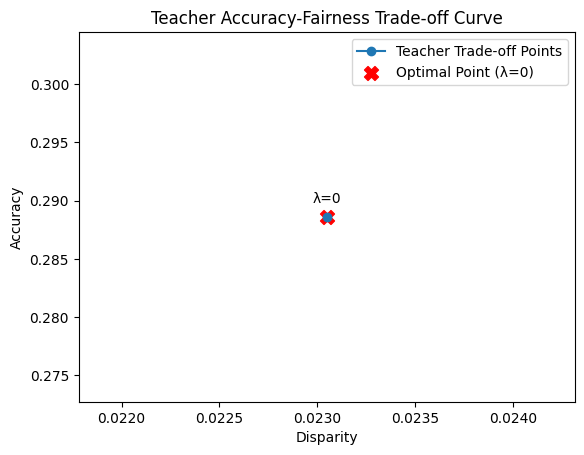

Optimal Lambda for Teacher: 0
Optimal Bias/Disparity for Teacher: 0.023049065466437636
Optimal Accuracy for Teacher: 0.2886002886002886
Optimal Weighted Ratio for Teacher: 0.28


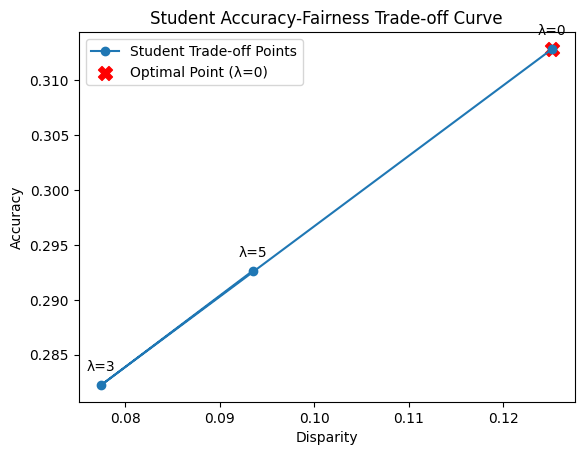

Optimal Lambda for Student: 0
Optimal Bias/Disparity for Student: 0.12520403018085313
Optimal Accuracy for Student: 0.31284271284271287
Optimal Weighted Ratio for Student: 0.28


In [75]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    bias_values = []
    accuracy_values = []

    if model_type == 'teacher':
        for lmda in lambdas:
            if lmda in model_results and 'teacher_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['teacher_mean_abs_val_disparity'][0])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[0] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][0])
        model_name = "Teacher"
    elif model_type == 'student':
        for lmda in lambdas:
            if lmda in model_results and 'student_mean_abs_val_disparity' in model_results[lmda]:
                bias_values.append(model_results[lmda]['student_mean_abs_val_disparity'])
                performance_key = next((key for key in model_results if isinstance(key, tuple) and key[1] == lmda), None)
                if performance_key:
                    accuracy_values.append(model_results[performance_key]['performance_metrics']['metrics']['accuracy'][1])
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")





    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")
    
# Plot for Teacher
plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list_teacher)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)

In [79]:
lambda_results

{0: {'teacher_mean_abs_val_disparity': [0.023049065466437636],
  'student_mean_abs_val_disparity': 0.12520403018085313},
 3: {'student_mean_abs_val_disparity': 0.07744457040615753},
 5: {'student_mean_abs_val_disparity': 0.0934800379238889},
 (0,
  0): {'performance_metrics': {'metrics': {'accuracy': (0.2886002886002886,
     0.31284271284271287),
    'precision': (0.36245232656034165, 0.33637310355095534),
    'recall': (0.2886002886002886, 0.31284271284271287),
    'f1': (0.26634462811590237, 0.27166407705664775)},
   'all_labels': array([2, 2, 2, ..., 1, 1, 1]),
   'all_teacher_preds': array([ 0,  2,  2, ..., 13,  2,  9]),
   'all_student_preds': array([0, 1, 2, ..., 0, 0, 9])}, 'teacher_params': 21292880, 'student_params': 11184720, 'teacher_time': 0.009275197982788086, 'student_time': 0.004413604736328125},
 (0,
  3): {'performance_metrics': {'metrics': {'accuracy': (0.2886002886002886,
     0.28225108225108225),
    'precision': (0.36245232656034165, 0.31844589828552744),
    're

In [76]:
def compare_performance_metrics_for_demo(teacher, student, dataloader):
    teacher.eval()
    student.eval()

    detailed_info = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        # Assuming gender or other attributes are part of 'target'
        attributes = batch['target'].to(device)  

        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)

        teacher_preds = torch.argmax(teacher_outputs, dim=1)
        student_preds = torch.argmax(student_outputs, dim=1)

        for i in range(inputs.size(0)):
            if teacher_preds[i] != labels[i] and student_preds[i] == labels[i]:
                info = {
                    'image': inputs[i],
                    'actual_class': labels[i].item(),
                    'teacher_pred_class': teacher_preds[i].item(),
                    'student_pred_class': student_preds[i].item(),
                    'actual_attribute': attributes[i].item(),  # Modify based on your dataset
                    # If your model also predicts attributes, include them here
                }
                detailed_info.append(info)

    return detailed_info



In [77]:
def plot_images_with_details(info_list, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.ravel()

    for i in range(rows * cols):
        if i < len(info_list):
            data = info_list[i]
            image = data['image']
            actual_class = data['actual_class']
            teacher_pred_class = data['teacher_pred_class']
            student_pred_class = data['student_pred_class']
            actual_attribute = data['actual_attribute']
            # Include teacher's and student's attribute predictions if available

            title = f'Actual: Class {actual_class}, Attr {actual_attribute}\n' + \
                    f'Teacher: Class {teacher_pred_class}\n' + \
                    f'Student: Class {student_pred_class}'

            axes[i].imshow(image.cpu().numpy().transpose(1, 2, 0))
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    plt.subplots_adjust(wspace=0.5)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

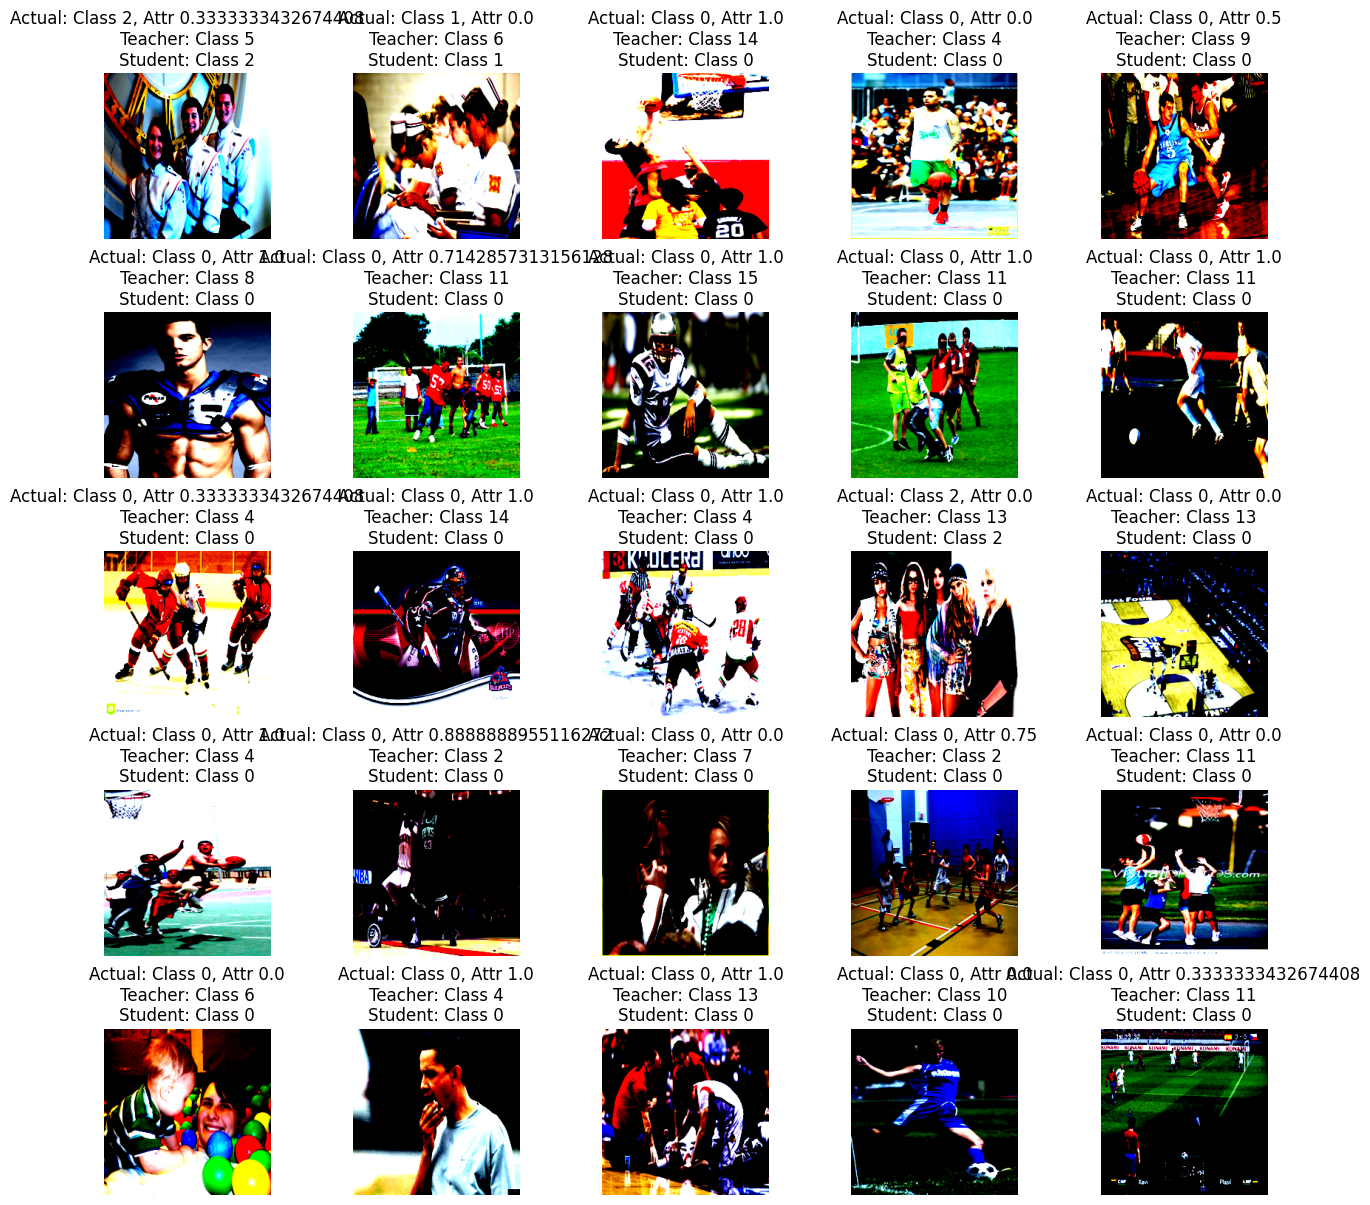

In [80]:
# Get detailed info where student is correct and teacher is wrong
detailed_info = compare_performance_metrics_for_demo(teacher_model, student_model, testloader)

# Display images with details
plot_images_with_details(detailed_info)
